In [1]:
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Normal directory for train set: chest_xray\train\NORMAL
Pneumonia directory for train set: chest_xray\train\PNEUMONIA
Normal directory for val set: chest_xray\val\NORMAL
Pneumonia directory for val set: chest_xray\val\PNEUMONIA
Normal directory for test set: chest_xray\test\NORMAL
Pneumonia directory for test set: chest_xray\test\PNEUMONIA


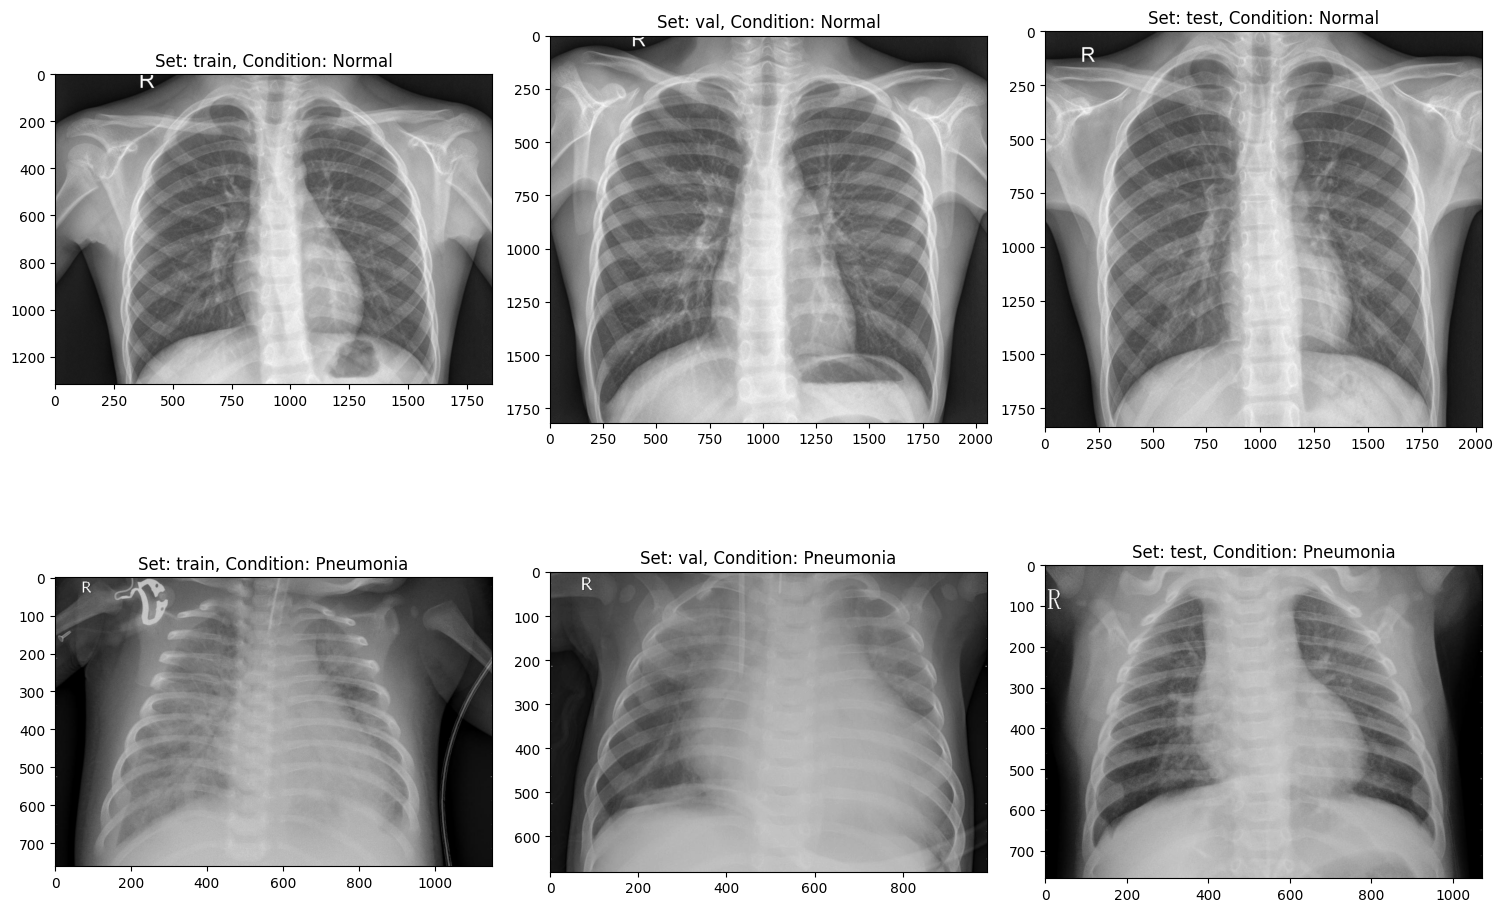

In [ ]:
# set random seed for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

# dataset path
path = 'chest_xray'

# Set up the matplotlib figure 
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
plt.tight_layout()

# Iterate over the datasets (train, val, test)
for i, _set in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(path, _set)  # Ensure proper path concatenation
    normal_dir = os.path.join(set_path, 'NORMAL')
    pneumonia_dir = os.path.join(set_path, 'PNEUMONIA')

    # Print the paths to ensure they are correct
    print(f"Normal directory for {_set} set: {normal_dir}")
    print(f"Pneumonia directory for {_set} set: {pneumonia_dir}")

    # Check if the directories exist
    if not os.path.isdir(normal_dir) or not os.path.isdir(pneumonia_dir):
        print(f"Directory not found for {_set} set.")
        continue

    # display a NORMAL image
    normal_images = os.listdir(normal_dir)
    if normal_images:
        ax[i].imshow(plt.imread(os.path.join(normal_dir, normal_images[0])), cmap='gray')
        ax[i].set_title(f'Set: {_set}, Condition: Normal')
    else:
        print(f"No images found in NORMAL directory for {_set} set.")

    # display a PNEUMONIA image
    pneumonia_images = os.listdir(pneumonia_dir)
    if pneumonia_images:
        ax[i+3].imshow(plt.imread(os.path.join(pneumonia_dir, pneumonia_images[0])), cmap='gray')
        ax[i+3].set_title(f'Set: {_set}, Condition: Pneumonia')
    else:
        print(f"No images found in PNEUMONIA directory for {_set} set.")

plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def process_data(img_dims, batch_size, path):
    # Data augmentation and rescaling for the training dataset
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # rescaling for the validation and test datasets
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # augmented data batches for training
    train_gen = train_datagen.flow_from_directory(
        directory=os.path.join(path, 'train'),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    # rescaled data batches for validation and testing
    test_gen = test_val_datagen.flow_from_directory(
        directory=os.path.join(path, 'test'),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    val_gen = test_val_datagen.flow_from_directory(
        directory=os.path.join(path, 'val'),
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    # Prepare the test data for evaluation purposes
    test_data, test_labels = [], []
    conditions = {'/NORMAL/': 0, '/PNEUMONIA/': 1}

    for cond, label in conditions.items():

        # Construct the directory path properly
        cond_clean = cond.strip('/') 
        img_dir = os.path.join(path, 'test', cond_clean)
        
        for img_name in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img_name)           
            img = cv2.imread(img_path)                      # to load it as a 3-channel color image
            img = cv2.resize(img, (img_dims, img_dims))     # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convert BGR to RGB to match what the model expects
            img = img.astype('float32') / 255.0             # Normalize

            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, val_gen, test_data, test_labels

img_dims = 150
batch_size = 32

# to Ensure this path is correct for the environment
path = 'chest_xray' 
train_gen, test_gen, val_gen, test_data, test_labels = process_data(img_dims, batch_size, path)

Found 4099 images belonging to 2 classes.
Found 880 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, SeparableConv2D, BatchNormalization, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

img_dims = 150
epochs = 12
batch_size = 32

# Process data to get training and testing generators
train_gen, test_gen, val_gen, test_data, test_labels = process_data(img_dims, batch_size, 'chest_xray')
# Define the input shape
inputs = Input(shape=(img_dims, img_dims, 3))

# First convolutional block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)  
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)       
x = MaxPool2D(pool_size=(2, 2))(x)                                                    

# Second convolutional block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = BatchNormalization()(x)                                                               
x = MaxPool2D(pool_size=(2, 2))(x)                                                      

# Third convolutional block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = BatchNormalization()(x)                                                               
x = MaxPool2D(pool_size=(2, 2))(x)                                                        

# Fourth convolutional block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = BatchNormalization()(x)                                                               
x = MaxPool2D(pool_size=(2, 2))(x)     
x = Dropout(rate=0.2)(x) # Dropout to prevent overfitting

# Fifth convolutional block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)  
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)                                                                
x = MaxPool2D(pool_size=(2, 2))(x)                                        
x = Dropout(rate=0.2)(x)

# Fully connected layer
x = Flatten()(x)                                    # Flatten the output
x = Dense(units=512, activation='relu')(x)          # First dense layer with 512 units
x = Dropout(rate=0.7)(x)                            # Dropout to prevent overfitting
x = Dense(units=128, activation='relu')(x)          # Second dense layer with 128 units
x = Dropout(rate=0.5)(x)                            
x = Dense(units=64, activation='relu')(x)           # Third dense layer with 64 units
x = Dropout(rate=0.3)(x)                            

# Output layer sigmoid activation
output = Dense(units=1, activation='sigmoid')(x)               

# Create and compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.weights.h5', save_best_only=True, save_weights_only=True)  # Save best model weights
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')         # Reduce learning rate on plateau
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')                    # Early stopping to avoid overfitting
model.summary()

Found 4099 images belonging to 2 classes.
Found 880 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 75, 75, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 75, 75, 32)     │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 37, 37, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 18, 18, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 9, 9, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 9, 9, 256)      │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,314,337 (8.83 MB)

 Trainable params: 2,313,377 (8.82 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# model training
hist = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    callbacks=[checkpoint, lr_reduce]
)

Epoch 1/12
129/129 ━━━━━━━━━━━━━━━━━━━━ 48s 345ms/step - accuracy: 0.8212 - loss: 0.3844 - val_accuracy: 0.7295 - val_loss: 0.6076 - learning_rate: 0.0010
Epoch 2/12
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.8878 - loss: 0.2870 - val_accuracy: 0.7295 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 3/12
129/129 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - accuracy: 0.9083 - loss: 0.2419 - val_accuracy: 0.7295 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 4/12
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.9200 - loss: 0.2306 - val_accuracy: 0.7295 - val_loss: 1.0062 - learning_rate: 0.0010
Epoch 5/12
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.9232 - loss: 0.2067 - val_accuracy: 0.7341 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 6/12
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9295 - loss: 0.1894
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - accuracy: 0.927

In [ ]:
# model evaluation
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])

print("\nTest Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

129/129 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.9610 - loss: 0.1136
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9523 - loss: 0.1226
Train Loss:  0.11359900236129761
Train Accuracy:  0.9609661102294922
--------------------
Test Loss:  0.1226450726389885
Test Accuracy:  0.9522727131843567


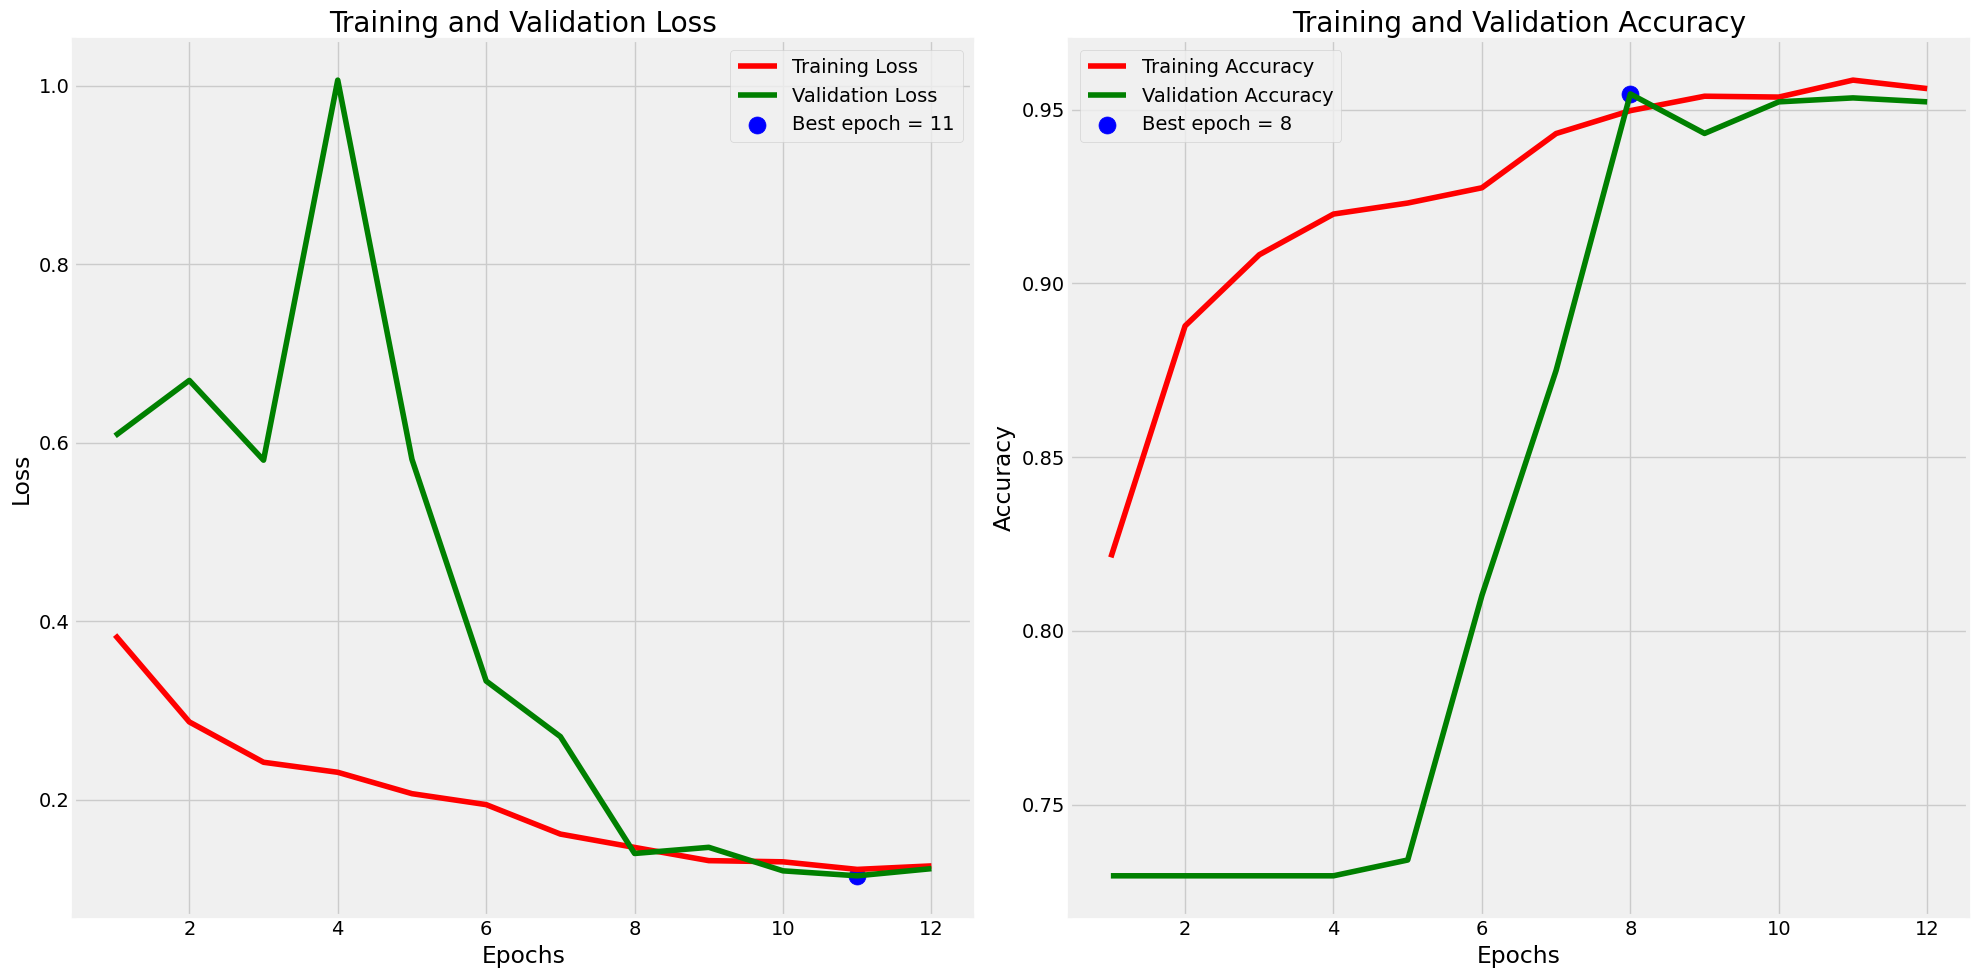

In [ ]:
# Extract training and validation accuracy and loss from the history object
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

# Identify the epoch with the lowest validation loss and highest validation accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# list of epochs for plotting 
Epochs = [i + 1 for i in range(len(tr_acc))]

# best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# plot size and style
plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')

# training and validation loss Plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# training and validation accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


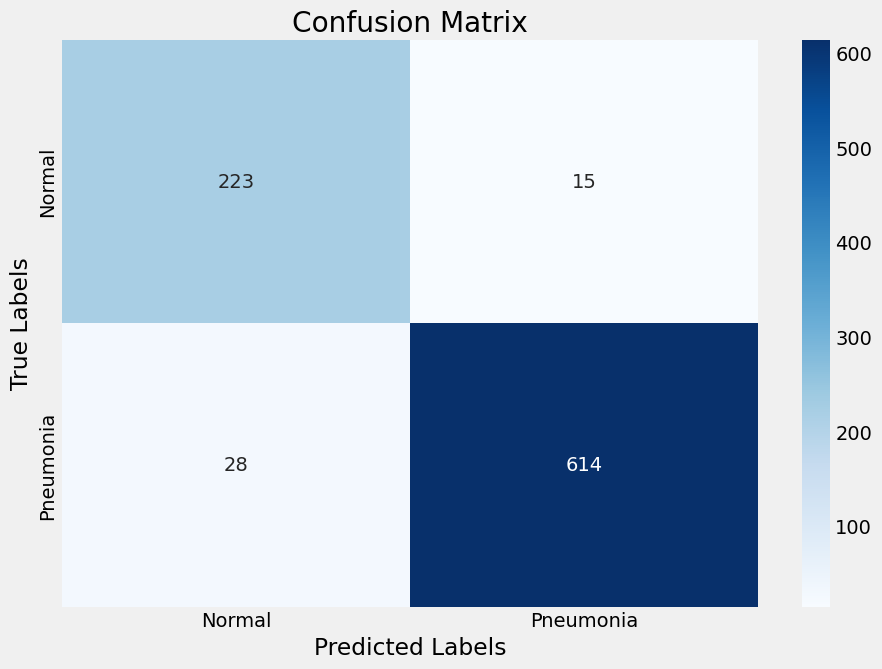

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict the labels
preds = model.predict(test_data)
rounded_preds = np.round(preds)

# confusion matrix
cm = confusion_matrix(test_labels, rounded_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# classification report
report = classification_report(test_labels, rounded_preds, target_names=['Normal', 'Pneumonia'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print('\nTEST METRICS')
print(report_df)




TEST METRICS
              precision    recall  f1-score     support
Normal         0.888446  0.936975  0.912065  238.000000
Pneumonia      0.976153  0.956386  0.966168  642.000000
accuracy       0.951136  0.951136  0.951136    0.951136
macro avg      0.932299  0.946681  0.939117  880.000000
weighted avg   0.952432  0.951136  0.951536  880.000000
